In [4]:
import keras
import os
import numpy as np
import re

In [5]:
'''
导入数据集
'''
filename_ptn = re.compile('(\d)_\d+.txt')
train_path = './Data/trainingDigits'
test_path = './Data/testDigits'
x_train = []
y_train = []
x_test = []
y_test = []

for filename in os.listdir(train_path):
    file = filename_ptn.search(filename)
    if file:
        file_path = os.path.join(train_path, filename)
        with open(file_path, 'r+') as f:
            x_train.append(f.read())
        y_train.append(file.group(1))

for filename in os.listdir(test_path):
    file = filename_ptn.search(filename)
    if file:
        file_path = os.path.join(test_path, filename)
        with open(file_path, 'r+') as f:
            x_test.append(f.read())
        y_test.append(file.group(1))


print('共有手写数字训练集：{}组\n'.format(len(x_train)))
print('共有手写数字测试集：{}组'.format(len(x_test)))

共有手写数字训练集：1934组

共有手写数字测试集：946组


In [6]:
'''
基于全连接网络对手写数字数据进行适当的处理
'''
def proceed_ann_x(x_lst):
    x_lst = x_lst.copy()
    for i, x in enumerate(x_lst):
        digit = ''.join(x.split('\n'))
        x_lst[i] = np.array([int(px) for px in digit]).reshape((1, -1))
    x_array = np.concatenate(x_lst)
    return x_array

x_train_ann = proceed_ann_x(x_train)
x_test_ann = proceed_ann_x(x_test)

print('训练集特征的维度：{}'.format(x_train_ann.shape))

训练集特征的维度：(1934, 1024)


In [7]:
'''
对labels进行处理
'''
def proceed_y(y_lst):
    for i, y in enumerate(y_lst):
        label = np.zeros((1, 10))
        label[0, int(y)] = 1
        y_lst[i] = label
    y_array = np.concatenate(y_lst)
    return y_array

y_train = proceed_y(y_train)
y_test = proceed_y(y_test)

print('训练集标签集的维度：{}'.format(y_train.shape))

训练集标签集的维度：(1934, 10)


In [8]:
'''
基于卷积神经网络网络对手写数字数据进行适当的处理
'''
def strseq2intseq(strseq):
    return [int(x) for x in strseq]

def proceed_cnn_x(x_lst):
    x_lst = x_lst.copy()
    for i, x in enumerate(x_lst):
        digit = np.array([np.array([strseq2intseq(seq) for seq in x.split('\n') if seq != ''])])
        x_lst[i] = digit
    x_array = np.concatenate(x_lst)
    x_array = x_array.reshape((list(x_array.shape) + [1]))
    return x_array

x_train_cnn = proceed_cnn_x(x_train)
x_test_cnn = proceed_cnn_x(x_test)

print('训练集特征的维度：{}'.format(x_train_cnn.shape))

训练集特征的维度：(1934, 32, 32, 1)


## 构建Keras全连接网络

In [9]:
from keras.models import Sequential
from keras.layers import Layer, Dense, MaxPool2D, Conv2D, Dropout, SimpleRNN, LSTM, GRU, Flatten, Input, Reshape
from keras.optimizers import adam_v2, sgd_experimental
from keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from keras.callbacks import Callback, LearningRateScheduler

### 分割训练集和测试集

In [10]:
def k_fold(data, labels, k, random_shuffle=True):
    data, labels = data.copy(), labels.copy()
    data_index = list(range(data.shape[0]))

    if random_shuffle == True:
        np.random.shuffle(data_index)
    
    for i in range(k):
        fold_size = int(np.floor(data.shape[0] / k) + 1)
        test_index = data_index[fold_size * i:fold_size * (i + 1)]
        train_index = data_index[:fold_size * i] + data_index[fold_size * (i + 1):]
        yield data[train_index], labels[train_index], data[test_index], labels[test_index]

def split(data, labels, proportion, random_shuffle=True):
    data, labels = data.copy(), labels.copy()
    data_index = list(range(data.shape[0]))

    if random_shuffle == True:
        np.random.shuffle(data_index)
        data, labels = data[data_index], labels[data_index]
    
    train_length = int(proportion * data.shape[0])
    return data[:train_length], labels[:train_length], data[train_length:], labels[train_length:]

### History Track

In [11]:
class History_Track(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.cat_accuracy = {'batch':[], 'epoch':[]}
        self.mse = {'batch':[], 'epoch':[]}
        self.rmse = {'batch':[], 'epoch':[]}
        self.mae = {'batch':[], 'epoch':[]}
    
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs['loss'])
        self.cat_accuracy['batch'].append(logs['cat_acc'])
        self.mse['batch'].append(logs['mse'])
        self.rmse['batch'].append(logs['rmse'])
        self.mae['batch'].append(logs['mae'])

    def on_epoch_end(self, epoch, logs={}):
        self.losses['epoch'].append(logs['loss'])
        self.cat_accuracy['epoch'].append(logs['cat_acc'])
        self.mse['epoch'].append(logs['mse'])
        self.rmse['epoch'].append(logs['rmse'])
        self.mae['epoch'].append(logs['mae'])

### 卷积神经网络

#### 构建模型

In [12]:
x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn = split(x_train_cnn, y_train, 0.8)

In [13]:
'''
构建卷积神经网络
'''
# 构建序列卷积模型
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1), activation='relu'))
cnn_model.add(MaxPool2D(2, 2))
cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(2, 2))
cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='softmax'))

# 生成评价指标和History Track Callback
cat_acc = keras.metrics.CategoricalAccuracy(name='cat_acc')
mse = keras.metrics.MeanSquaredError(name='mse')
rmse = keras.metrics.RootMeanSquaredError(name='rmse')
mae = keras.metrics.MeanAbsoluteError(name='mae')
adam = adam_v2.Adam(learning_rate=0.01)
cnn_history_track = History_Track()

cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=[cat_acc, mse, rmse, mae], 
)
cnn_model.summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          2320      
                                        

2022-05-02 12:33:57.841770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 12:33:57.841884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 训练准确率

In [14]:
'''
训练准确率
'''
cnn_model.fit(x_train_cnn, y_train_cnn,
    epochs=100,
    batch_size=200,
    verbose=1,
    validation_data=(x_val_cnn, y_val_cnn), 
    callbacks=cnn_history_track, 
)

Epoch 1/100


2022-05-02 12:33:58.086488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 12:33:58.345423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 50ms/step - loss: 2.2132 - cat_acc: 0.1823 - mse: 0.0877 - rmse: 0.2961 - mae: 0.1764 - val_loss: 1.5194 - val_cat_acc: 0.5943 - val_mse: 0.0641 - val_rmse: 0.2532 - val_mae: 0.1455
Epoch 2/100
5/8 [=================>............] - ETA: 0s - loss: 1.4887 - cat_acc: 0.4950 - mse: 0.0633 - rmse: 0.2516 - mae: 0.1292

2022-05-02 12:33:58.928929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 20ms/step - loss: 1.3538 - cat_acc: 0.5339 - mse: 0.0589 - rmse: 0.2427 - mae: 0.1209 - val_loss: 0.5546 - val_cat_acc: 0.8682 - val_mse: 0.0251 - val_rmse: 0.1584 - val_mae: 0.0639
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.7493 - cat_acc: 0.7498 - mse: 0.0349 - rmse: 0.1868 - mae: 0.0707 - val_loss: 0.2622 - val_cat_acc: 0.9302 - val_mse: 0.0117 - val_rmse: 0.1083 - val_mae: 0.0304
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.4564 - cat_acc: 0.8513 - mse: 0.0212 - rmse: 0.1457 - mae: 0.0423 - val_loss: 0.2053 - val_cat_acc: 0.9147 - val_mse: 0.0102 - val_rmse: 0.1011 - val_mae: 0.0206
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3670 - cat_acc: 0.8862 - mse: 0.0169 - rmse: 0.1299 - mae: 0.0349 - val_loss: 0.1558 - val_cat_acc: 0.9561 - val_mse: 0.0066 - val_rmse: 0.0811 - val_mae: 0.0148
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - lo

#### 测试集准确率

In [15]:
'''
测试集准确率
'''
def cat_accuracy(y_pred, y_real):
    right_num = 0
    for i in range(y_pred.shape[1]):
        i_pred = np.argmax(y_pred.T[i])
        i_real = np.argmax(y_real.T[i])
        if i_pred == i_real:
            right_num += 1
    return right_num / y_pred.shape[1]

y_pred = cnn_model.predict(x_test_cnn)
cat_acc = cat_accuracy(y_pred.T, y_test.T)
print('经过100epochs的迭代：')
print('该神经网络在测试集上的准确率为：{:.02f}%'.format(cat_acc * 100))

经过100epochs的迭代：
该神经网络在测试集上的准确率为：98.94%


2022-05-02 12:34:14.796050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


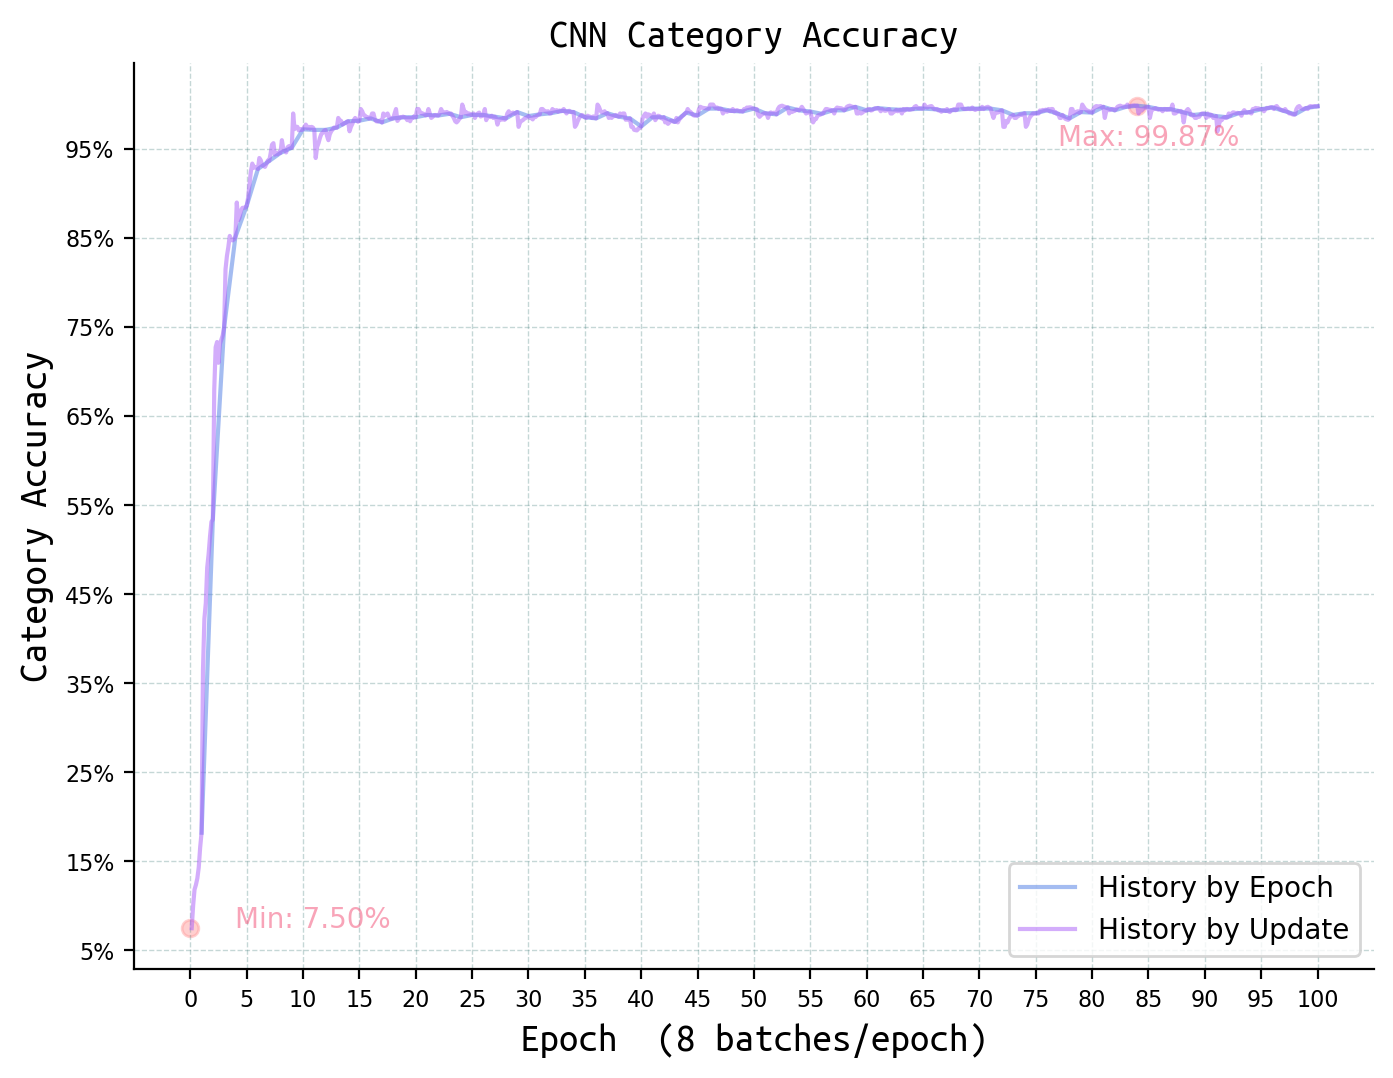

In [16]:
from Plot import plot_cat_acc

acc_epoch = cnn_history_track.cat_accuracy['epoch']
acc_update = cnn_history_track.cat_accuracy['batch']

fig, ax = plot_cat_acc(acc_epoch, acc_update, 8, 'CNN Category Accuracy')

### 全连接神经网络

In [17]:
x_train_ann, y_train_ann, x_val_ann, y_val_ann = split(x_train_ann, y_train, 0.8)

#### 

In [18]:
'''
全连接神经网络
'''
# 构建序列卷积模型
nn_model = Sequential()
nn_model.add(Dense(256, activation='relu', input_shape=(1024,)))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(10, activation='softmax'))

# 生成评价指标和History Track Callback
cat_acc = keras.metrics.CategoricalAccuracy(name='cat_acc')
mse = keras.metrics.MeanSquaredError(name='mse')
rmse = keras.metrics.RootMeanSquaredError(name='rmse')
mae = keras.metrics.MeanAbsoluteError(name='mae')
adam = adam_v2.Adam(learning_rate=0.01)
nn_history_track = History_Track()

nn_model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=[cat_acc, mse, rmse, mae], 
)
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 279,498
Trainable params: 279,498
Non-trainable params: 0
_________________________________________________________________


#### 训练准确率

In [ ]:
'''
训练准确率
'''
nn_model.fit(x_train_ann, y_train_ann,
    epochs=100,
    batch_size=200,
    verbose=1,
    callbacks=nn_history_track, 
    validation_data=(x_val_ann, y_val_ann), 
)

#### 测试集准确率

In [ ]:
y_pred = nn_model.predict(x_test_ann)
cat_acc = cat_accuracy(y_pred.T, y_test.T)
print('经过100epochs的迭代：')
print('该神经网络在测试集上的准确率为：{:.02f}%'.format(cat_acc * 100))

In [ ]:
from Plot import plot_cat_acc

acc_epoch = nn_history_track.cat_accuracy['epoch']
acc_update = nn_history_track.cat_accuracy['batch']

fig, ax = plot_cat_acc(acc_epoch, acc_update, 8, 'Dense Neural Network Category Accuracy')

### 循环神经网络

In [19]:
'''
构建卷积神经网络
'''
# 构建序列卷积模型
cr_model = Sequential()
cr_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1), activation='relu'))
cr_model.add(MaxPool2D(2, 2))
cr_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
cr_model.add(MaxPool2D(2, 2))
cr_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
cr_model.add(MaxPool2D(2,2))
cr_model.add(Reshape((16, 16)))
cr_model.add(LSTM(128, activation='relu'))
cr_model.add(Dropout(0.5))
cr_model.add(Dense(64, activation='relu'))
cr_model.add(Dropout(0.5))
cr_model.add(Dense(10, activation='softmax'))

# 生成评价指标和History Track Callback
cat_acc = keras.metrics.CategoricalAccuracy(name='cat_acc')
mse = keras.metrics.MeanSquaredError(name='mse')
rmse = keras.metrics.RootMeanSquaredError(name='rmse')
mae = keras.metrics.MeanAbsoluteError(name='mae')
adam = adam_v2.Adam(learning_rate=0.01)
cr_history_track = History_Track()

cr_model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=[cat_acc, mse, rmse, mae], 
)
cr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)        

In [ ]:
'''
训练准确率
'''
cr_model.fit(x_train_cnn, y_train_cnn,
    epochs=100,
    batch_size=200,
    verbose=1,
    validation_data=(x_val_cnn, y_val_cnn), 
    callbacks=cr_history_track, 
)

In [ ]:
'''
测试集准确率
'''
y_pred = cr_model.predict(x_test_cnn)
cat_acc = cat_accuracy(y_pred.T, y_test.T)
print('经过100epochs的迭代：')
print('该神经网络在测试集上的准确率为：{:.02f}%'.format(cat_acc * 100))

In [ ]:
from Plot import plot_cat_acc

acc_epoch = cr_history_track.cat_accuracy['epoch']
acc_update = cr_history_track.cat_accuracy['batch']

fig, ax = plot_cat_acc(acc_epoch, acc_update, 8, 'CNN & LSTM Category Accuracy')

In [1]:
import numpy as np

In [81]:
a = np.arange(25).reshape((1, 1, 5, 5))
def foreward(xs_mats):  # 4 dimension
    foreward_mats = np.zeros(xs_mats.shape)
    ys_mats = np.zeros(list(xs_mats.shape[:2]) + [3, 3])  # 4 dimension
    for image_i, image_mats in enumerate(xs_mats):
        for mat_i, image_mat in enumerate(image_mats):
            height_range = np.arange(0, image_mat.shape[0], 2)
            width_range = np.arange(0, image_mat.shape[1], 2)
            for h_i, h in enumerate(height_range):
                for w_i, w in enumerate(width_range):
                    sub_mat = image_mat[h:h + 2, w:w + 2]
                    sub_mat_h, sub_mat_w = sub_mat.shape
                    ys_mats[image_i][mat_i][h_i, w_i] = np.max(sub_mat)
                    max_index = np.argmax(sub_mat)
                    max_h = max_index // sub_mat_w
                    max_w = max_index % sub_mat_w
                    foreward_mats[image_i][mat_i][h:h + 2, w:w + 2][max_h, max_w] = 1
    return ys_mats, foreward_mats
mid_val, b = foreward(a)
mid_val

array([[[[ 6.,  8.,  9.],
         [16., 18., 19.],
         [21., 23., 24.]]]])

In [82]:
def backward(xs_mats, trainable=True, learning_rate=0.01):
    ys_mats = b
    for image_i, image_mats in enumerate(xs_mats):
        for layer, image_mat in enumerate(image_mats):
            for h in range(image_mat.shape[0]):
                for w in range(image_mat.shape[1]):
                    ys_mats[image_i, layer, 2*h:2*(h+1), \
                        2*w:2*(w+1)] *= image_mat[h, w]
    return ys_mats
backward(mid_val)

array([[[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  6.,  0.,  8.,  9.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0., 16.,  0., 18., 19.],
         [ 0., 21.,  0., 23., 24.]]]])

In [3]:
class Pool(object):
    def __init__(self, step):
        self.step = step
        self.foreward_mats = None
        self.input_mat_shape = None
        self.output_mat_shape = None
    
    def activate_layer(self, input_shape):  # input_shape: 3 dimension
        self.input_mat_shape = list(input_shape[1:])
        output_height = np.ceil(input_shape[1] / self.step)
        output_width = np.ceil(input_shape[2] / self.step)
        self.output_mat_shape = [output_height, output_width]
        return (input_shape[0], output_height, output_width)

    def foreward(self, xs_mats):  # 4 dimension
        self.os = xs_mats.copy()
        self.foreward_mats = np.zeros(self.os.shape)
        ys_mats = np.zeros(list(xs_mats.shape[:2]) + self.output_mat_shape)  # 4 dimension
        for image_i, image_mats in enumerate(xs_mats):
            for mat_i, image_mat in enumerate(image_mats):
                height_range = np.arange(0, image_mat.shape[0], self.step)
                width_range = np.arange(0, image_mat.shape[1], self.step)
                for h_i, h in enumerate(height_range):
                    for w_i, w in enumerate(width_range):
                        sub_mat = image_mat[h:h + self.step, w:w + self.step]
                        sub_mat_h, sub_mat_w = sub_mat.shape
                        ys_mats[image_i][mat_i][h_i, w_i] = np.max(sub_mat)
                        max_index = np.argmax(sub_mat)
                        max_h = max_index // sub_mat_w
                        max_w = max_index % sub_mat_w
                        self.forward_mats[image_i][mat_i][h:h + self.step, w:w + self.step][max_h, max_w] = 1
        return ys_mats

    def backward(self, xs_mats, trainable=True, learning_rate=0.01):
        ys_mats = self.foreward_mat
        for image_i, image_mats in enumerate(xs_mats):
            for layer, image_mat in enumerate(image_mats):
                for h in range(image_mat.shape[0]):
                    for w in range(image_mat.shape[1]):
                        ys_mats[image_i, layer, self.step*h:self.step*(h+1), \
                            self.step*w:self.step*(w+1)] *= image_mat[h, w]
        return ys_mats